In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import math
import matplotlib.pyplot as plt
from importlib import reload


# Data processing

In [94]:
users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
ratings=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/ratings.dat',sep="::",names=['UserID','MovieID','Rating','Timestamp'])

<ipython-input-94-4c609c110fe4>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
<ipython-input-94-4c609c110fe4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
<ipython-input-94-4c609c110fe4>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as r

Split train - test set

In [95]:
u=len(users)
m=max(movies["MovieID"])
r_train,r_test=train_test_split(ratings,test_size=0.1,stratify=ratings['UserID'])

# r_train.head()

# User-user model

Utility matrix

In [96]:
user_item=np.full((u,m),np.nan)
for r in r_train.itertuples():
    user_item[r[1]-1][r[2]-1]=r[3]

user_item_test=np.full((u,m),np.nan)
for r in r_test.itertuples():
    user_item_test[r[1]-1][r[2]-1]=r[3]
# user_item

Similarity matrix

In [97]:
mean=np.nanmean(user_item,axis=1)
for i in range(u):
    user_item[i]=user_item[i]-mean[i]
    user_item_test[i] = user_item_test[i] - mean[i]

nan_cell=np.argwhere(np.isnan(user_item))

user_item=np.nan_to_num(user_item)

In [98]:
nan_list=[[] for i in range(u)]
for cell in nan_cell:
    nan_list[cell[1]].append(cell[0])
# nan_cell

In [99]:
def similarity(x,y):
    if np.dot(x,y)==0:
        return 0
    return np.dot(x,y)/math.sqrt(np.sum(x**2)*np.sum(y**2))

In [100]:
similarity_matrix=np.full((u,u),np.nan)
for user_1 in range(u):
    for user_2 in range(user_1+1):
        res=similarity(user_item[user_1],user_item[user_2])
        similarity_matrix[user_1][user_2]=res
        similarity_matrix[user_2][user_1]=res

similarity_matrix

array([[ 1.        ,  0.01802768,  0.03895508, ...,  0.        ,
         0.00855648,  0.0181934 ],
       [ 0.01802768,  1.        ,  0.03344957, ..., -0.01378875,
         0.0195799 , -0.01070529],
       [ 0.03895508,  0.03344957,  1.        , ...,  0.05107844,
         0.02525719, -0.05064539],
       ...,
       [ 0.        , -0.01378875,  0.05107844, ...,  1.        ,
         0.03713582, -0.04259037],
       [ 0.00855648,  0.0195799 ,  0.02525719, ...,  0.03713582,
         1.        ,  0.04636822],
       [ 0.0181934 , -0.01070529, -0.05064539, ..., -0.04259037,
         0.04636822,  1.        ]])

In [101]:
similarity_matrix=np.nan_to_num(similarity_matrix)
mean=np.nan_to_num(mean)

In [102]:
def predict(user,movie,k):
    copy=np.array(similarity_matrix[user])
    np.delete(copy,nan_list[user])
    neighbor=(-copy).argsort()[1:k+1]
    similar=copy[neighbor]
    rate=user_item.T[movie][neighbor]
    if np.sum(similar)!=0:
        return (rate@similar)/np.sum(np.abs(similar))
    return 0

In [103]:
def predict_matrix(k):
    matrix=user_item.copy()
    for r in r_test.itertuples():
        pred=predict(r[1]-1,r[2]-1,k)
        matrix[r[1]-1][r[2]-1] = pred
    return matrix

# Evaluation

# Metric function

In [104]:
def RMSE(pred, test):
    rmse=0
    mae=0
    for user in range(u):
        e=pred[user]-test[user]
        rmse+=np.nanmean(np.square(e))
        mae+=np.nanmean(np.abs(e))
    return (rmse/u, mae/u)

In [105]:
def PrecisionAtK(Y,K):
    X=user_item_test.copy()
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    precisionK=[]
    recallK=[]
    f1K=[]
    mapK=[]
    for user in range(u):
        rcm = rcm_movie[user]
        rcm = rcm[np.argwhere(Y[user][rcm] > 0)]
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = np.intersect1d(rcm, rcm_test)
        rcm_test = rcm_test[np.argwhere(X[user][rcm_test] > 0)]
        rcm = rcm[:K]

        precision=np.in1d(rcm,rcm_test)
        recall=np.in1d(rcm_test,rcm)

        map=[]
        for k in range(len(rcm)):
            p = np.mean(precision[:k+1])*precision[k]
            if p>0:
                map.append(p)

        precision=np.mean(precision)
        recall=np.mean(recall)
        f1=0
        if precision + recall != 0:
            f1 = 2*precision*recall/(precision+recall)
        precisionK.append(precision)
        recallK.append(recall)
        f1K.append(f1)
        mapK.append(np.mean(map))

    precisionK=np.nan_to_num(precisionK)
    recallK=np.nan_to_num(recallK)
    f1K=np.nan_to_num(f1K)
    mapK=np.nan_to_num(mapK)

    return (np.mean(precisionK), np.mean(recallK), np.mean(f1K), np.mean(mapK))

In [124]:
def NDCG(Y,K):
    X=user_item_test.copy()
    for i in range(u):
        X[i] += mean[i]
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    ndcg=[]
    for user in range(u):
        dcg=0
        idcg=0
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = rcm_movie[user][np.in1d(rcm_movie[user], rcm_test)]
        for i in range(len(rcm[:K])):
            dcg += (2**X[user][rcm[i]]-1)/math.log(i+2, 2)
            idcg += (2**X[user][rcm_test[i]]-1)/math.log(i+2, 2)
        if np.isnan(dcg/idcg):
            ndcg.append(1)
        else:
            ndcg.append(dcg/idcg)
    return np.mean(ndcg)

# Test for number of neighbor

In [107]:
rmse = []
mae = []
precision = []
recall = []
f1 = []

iteration_list = [5,15,30,50,100, 200]

for k in iteration_list:
    user_item = predict_matrix(k)
    e=RMSE(user_item, user_item_test)
    rmse.append(e[0])
    mae.append(e[1])

    metric=PrecisionAtK(user_item, 10000)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RMSE:  [0.99947480007134, 0.9749069762413073, 0.9699364086397331, 0.9681486918698963, 0.968097210471669, 0.9703543276628294]
MAE:  [0.791173061830039, 0.780489511562454, 0.7778036720267658, 0.7768879486022437, 0.776603596650018, 0.7772525754358817]


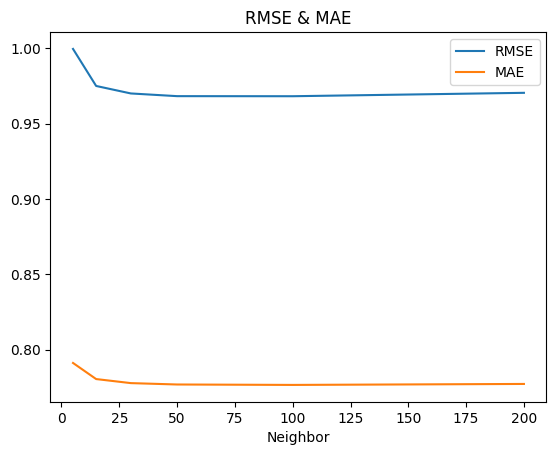

In [122]:
print("RMSE: ",rmse)
print('MAE: ', mae)
plt=reload(plt)
plt.plot(iteration_list, rmse, label='RMSE')
plt.plot(iteration_list, mae, label='MAE')
plt.xlabel('Neighbor')
plt.title('RMSE & MAE')
plt.legend()
plt.show()

Precision:  [0.5765955760336386, 0.6263188986237378, 0.6464832303071429, 0.6520217905363394, 0.6540248551706423, 0.6581093965054573]
Recall:  [0.40639434562719035, 0.5835541389495887, 0.6619817760717795, 0.6989134613975091, 0.7297146358755607, 0.7488646700808309]
F1:  [0.4438380176360222, 0.5734484329191577, 0.624417429457056, 0.645566229664706, 0.6604871236198153, 0.670998899523039]


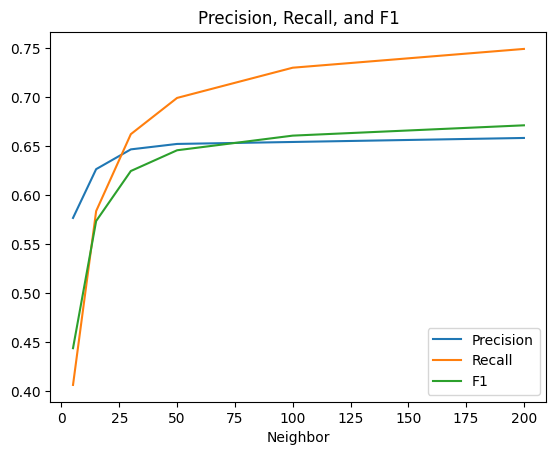

In [109]:
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)
plt=reload(plt)
plt.plot(iteration_list, precision,label='Precision')
plt.plot(iteration_list, recall, label='Recall')
plt.plot(iteration_list, f1, label='F1')
plt.xlabel('Neighbor')
plt.title('Precision, Recall, and F1')
plt.legend()
plt.show()

# Test for number of movie recommend

In [125]:
precision = []
recall = []
f1 = []
ndcg = []
map=[]
num_movie = [5,15,30,50,100]
user_item = predict_matrix(30)
for k in num_movie:
    metric=PrecisionAtK(user_item, k)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])
    map.append(metric[3])

    ndcg.append(NDCG(user_item, k))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Precision:  [0.6554690949227374, 0.648936998891469, 0.6471338589380967, 0.646533730911276, 0.6464815799958397]
Recall:  [0.46312060184715953, 0.6089577049368766, 0.6525588512736314, 0.6623541101787793, 0.6638744596581386]
F1:  [0.4901471760651217, 0.5934764316639789, 0.6197729579320753, 0.624993683376557, 0.625785344882896]


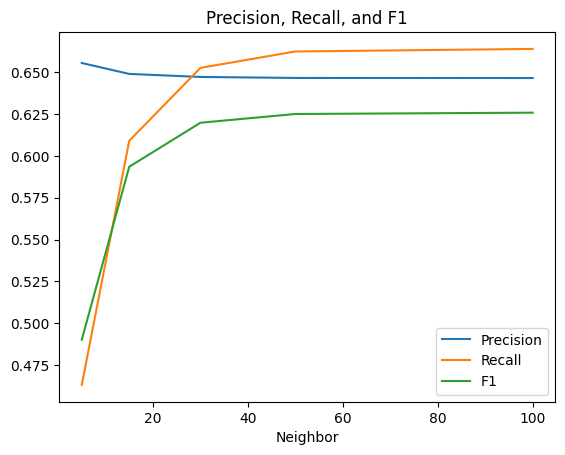

In [114]:
print("Precision: ",precision)
print('Recall: ', recall)
print('F1: ', f1)
plt=reload(plt)
plt.plot(num_movie, precision,label='Precision')
plt.plot(num_movie, recall, label='Recall')
plt.plot(num_movie, f1, label='F1')
plt.xlabel('Neighbor')
plt.title('Precision, Recall, and F1')
plt.legend()
plt.show()

MAP:  [0.746987444812362, 0.7323865136729396, 0.7307083264908664, 0.7304266668749282, 0.7304011480087227]
NDCG:  [0.8255458581805648, 0.8775910129832698, 0.8987189435910456, 0.9057779216049833, 0.9088237494107708]


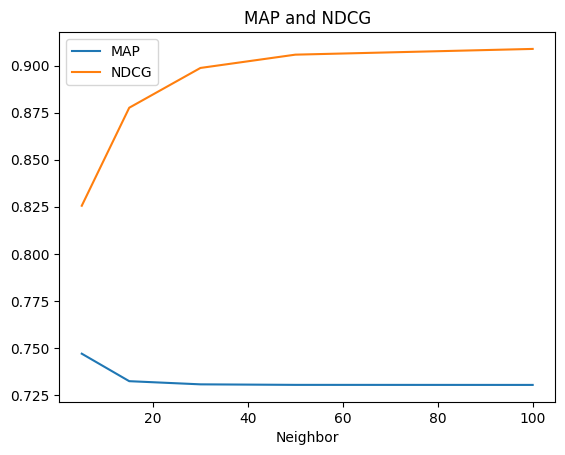

In [126]:
print("MAP: ",map)
print('NDCG: ', ndcg)
plt=reload(plt)
plt.plot(num_movie, map, label='MAP')
plt.plot(num_movie, ndcg, label ='NDCG')
plt.xlabel('Neighbor')
plt.title('MAP and NDCG')
plt.legend()
plt.show()